In [1]:
# Okay, let's get the proper transformations, and also get all the predictions on a subwindow scale - Later as a proof of concept, we will separate the sequences with densities all zero and see how the predicted densities look like.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

In [3]:
# path to dataframes
path_to_dfs = "data/BLAR_implementation/Block_0106/forecasted_counts"

In [4]:
len(os.listdir(path_to_dfs))

9632

In [5]:
len(os.listdir(path_to_dfs)) / 1376

7.0

In [6]:
averaged_forecasts_csvs = []
for file in os.listdir(path_to_dfs):
    if file[:8] =='averaged':
        averaged_forecasts_csvs.append(file)

In [7]:
# how many csv files do we have?
len(averaged_forecasts_csvs)

1376

In [8]:
averaged_forecasts_csvs[0]

'averaged_forecasts_sub_986.csv'

In [9]:
# let's create these names in the order of the subwindows
ordered_csv_files = ['averaged_forecasts_sub_' + str(i) + '.csv' for i in range(1376)]

In [10]:
# ordered_csv_files

In [11]:
%%time
all_dfs = []
for file in ordered_csv_files:
    read_df = pd.read_csv(path_to_dfs + '/' + file)
    all_dfs.append(read_df)

CPU times: user 2.1 s, sys: 433 ms, total: 2.53 s
Wall time: 10.6 s


In [12]:
# make a single dataframe out of the many
combined_df = pd.concat(all_dfs, axis = 1)

In [13]:
combined_df.head()

,True_value,Forecasted_value,True_value,Forecasted_value,True_value,Forecasted_value,True_value,Forecasted_value,True_value,Forecasted_value,...,True_value,Forecasted_value,True_value,Forecasted_value,True_value,Forecasted_value,True_value,Forecasted_value,True_value,Forecasted_value
0,1.609504,1.571414,1.609504,1.668503,1.623061,1.838900,2.052035,1.879698,2.079479,1.906690,...,0.295693,0.001280,0.295693,-0.021627,0.295693,0.016017,0.265922,0.020061,5.335567e-05,0.002983
1,1.615548,1.587427,1.960663,1.646610,2.179480,1.882276,2.201178,1.822688,2.301641,1.824984,...,0.000030,0.001697,0.000030,-0.021574,0.000030,0.011256,0.000020,0.020243,1.510827e-10,0.005567
2,1.620271,1.596834,1.686071,1.700732,2.137034,1.946469,2.220570,1.747421,2.308009,1.761618,...,0.000000,0.008321,0.000000,-0.003918,0.000000,0.007924,0.000000,0.014477,0.000000e+00,0.002687
3,1.762854,1.588429,1.927517,1.472848,1.992121,1.755661,2.077816,1.720972,2.002464,1.735776,...,0.000155,-0.001367,0.000155,0.016561,0.000155,0.020139,0.000113,0.026995,1.962633e-09,0.007457
4,1.680800,1.600358,2.084387,1.565815,2.111817,1.806263,2.220084,1.667842,2.217691,1.667193,...,0.000000,0.005750,0.000000,0.005835,0.000000,-0.006685,0.000000,0.012389,0.000000e+00,0.000417


In [14]:
combined_df.shape

(7, 2752)

In [15]:
# get the true values
True_values_df = combined_df[['True_value']]

In [16]:
True_values_df.head()

,True_value,True_value,True_value,True_value,True_value,True_value,True_value,True_value,True_value,True_value,...,True_value,True_value,True_value,True_value,True_value,True_value,True_value,True_value,True_value,True_value
0,1.609504,1.609504,1.623061,2.052035,2.079479,2.122541,1.837202,1.704743,1.609432,1.609432,...,2.958088e-01,2.958083e-01,2.956950e-01,0.295693,0.295693,0.295693,0.295693,0.295693,0.265922,5.335567e-05
1,1.615548,1.960663,2.179480,2.201178,2.301641,2.196594,1.978801,1.791785,1.791759,1.791759,...,3.049316e-05,3.049316e-05,3.049316e-05,0.000030,0.000030,0.000030,0.000030,0.000030,0.000020,1.510827e-10
2,1.620271,1.686071,2.137034,2.220570,2.308009,2.286751,2.095992,1.826375,1.791759,1.791759,...,4.874043e-07,4.315531e-07,7.558754e-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
3,1.762854,1.927517,1.992121,2.077816,2.002464,1.854905,1.390303,1.386287,1.386287,1.386287,...,5.317560e-02,2.701670e-02,1.550962e-04,0.000155,0.000155,0.000155,0.000155,0.000155,0.000113,1.962633e-09
4,1.680800,2.084387,2.111817,2.220084,2.217691,1.858954,1.609438,1.608935,1.608935,1.608935,...,2.956934e-01,2.950491e-01,7.729304e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


In [17]:
True_values_df.shape

(7, 1376)

In [18]:
# get the proper counts? - Do the transformation
exp_true = np.exp(True_values_df)-1

In [19]:
exp_true

,True_value,True_value,True_value,True_value,True_value,True_value,True_value,True_value,True_value,True_value,...,True_value,True_value,True_value,True_value,True_value,True_value,True_value,True_value,True_value,True_value
0,4.000330,4.000330,4.068581,6.783727,7.000300,7.352337,5.278944,4.499970,3.999970,3.999970,...,3.442131e-01,3.442124e-01,3.440601e-01,0.344058,0.344058,0.344058,0.344058,0.344058,0.304633,5.335709e-05
1,4.030646,6.104034,7.841708,8.035654,8.990561,7.994322,6.234064,5.000152,4.999997,4.999997,...,3.049362e-05,3.049362e-05,3.049362e-05,0.000030,0.000030,0.000030,0.000030,0.000030,0.000020,1.510827e-10
2,4.054460,4.398228,7.474269,8.212584,9.054390,8.842904,7.133508,5.211331,5.000000,5.000000,...,4.874045e-07,4.315532e-07,7.558754e-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
3,4.829047,5.872423,6.331070,6.987004,6.407286,5.391088,3.016066,2.999969,2.999969,2.999969,...,5.461482e-02,2.738496e-02,1.551082e-04,0.000155,0.000155,0.000155,0.000155,0.000155,0.000113,1.962633e-09
4,4.369852,7.039662,7.263241,8.208106,8.186097,5.417024,4.000000,3.997484,3.997484,3.997484,...,3.440580e-01,3.431923e-01,7.759252e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
5,6.069056,8.838747,9.007943,9.007943,8.893198,6.501209,4.158126,3.999845,3.999845,3.999845,...,3.599465e-02,3.594255e-02,3.566520e-02,0.035665,0.035665,0.035665,0.035665,0.035665,0.035660,4.087086e-03
6,5.211973,6.968062,7.997484,8.000000,7.999930,6.622587,3.843317,3.000031,3.000000,3.000000,...,2.715082e-02,2.715071e-02,1.235791e-02,0.004599,0.004599,0.004599,0.004599,0.004599,0.004348,3.098204e-06


In [20]:
# Identify the maximum and the minimum true values we have for the test data

In [21]:
exp_true.values.min(), exp_true.values.max()

(0.0, 11.025154977031994)

In [22]:
# Okay, so the highest true value we have is ~3. let's get teh min and max values for the predicted exponentiated values also

In [23]:
all_forecasts_npy_files = []
for file in os.listdir(path_to_dfs):
    if file[:13] == 'all_forecasts':
        all_forecasts_npy_files.append(file)

In [24]:
len(all_forecasts_npy_files)

1376

In [25]:
all_forecasts_npy_files[0]

'all_forecasts_sub_1104.npy'

In [26]:
# load just the first file
sub_273_forecasts = np.load(os.path.join(path_to_dfs, all_forecasts_npy_files[0]))

In [27]:
sub_273_forecasts.shape

(1000, 4, 7)

In [28]:
# Okay, so for the subwindow 273 -  this file seem to have all the 1000 values in the 4 chains for all the test time points in the sequence

In [29]:
# transform these values?
sub_273_forecasts = np.exp(sub_273_forecasts) - 1

In [30]:
sub_273_forecasts.min(), sub_273_forecasts.max()

(-0.95857465, 361.23315)

In [31]:
# get rid of anything below zero?
sub_273_forecasts[sub_273_forecasts < 0] = 0

In [32]:
sub_273_forecasts.min(), sub_273_forecasts.max()

(0.0, 361.23315)

In [33]:
# cool -  what does these values mean?

In [34]:
# try averaging the forecasted values along the 0th and 1st axis?

In [35]:
sub_273_forecasts_averged = np.mean(sub_273_forecasts, axis = (0,1))

In [36]:
sub_273_forecasts_averged

array([2.308993 , 2.3616743, 2.75495  , 2.9880307, 4.6564655, 5.1344666,
       5.4548216], dtype=float32)

In [37]:
sub_273_forecasts_averged.shape

(7,)

In [38]:
# sanity check

In [39]:
# sanity check
for i in range(sub_273_forecasts.shape[-1]):
    track = sub_273_forecasts[:,:,i]
    print(np.mean(track))

2.3089917
2.361675
2.754954
2.9880319
4.6564703
5.1344666
5.4548283


In [40]:
# Verify the shape of the true values - these are at a subwindow level, and we can use these as they are for getting the metrics, and the scatterplots?

In [41]:
exp_true.shape

(7, 1376)

In [42]:
# Okay, we need the predictions for the subwindows in the same shape? - but before that, we need to do the transformation for all the npy files. We can do this in a loop - we have done this before, use the code as it is.

In [43]:
%%time
catch_all_averaged_preds = []
for i in range(exp_true.shape[1]):
    file_name = "all_forecasts_sub_" + str(i) + '.npy'
    al_forecasts_npy_file = np.load(os.path.join(path_to_dfs, file_name))
    # make the conversion
    sub_window_forecasts = np.exp(al_forecasts_npy_file) - 1
    # get rid of anything below zero?
    sub_window_forecasts[sub_window_forecasts < 0] = 0
    # get averages over time 
    sub_window_forecasts_averaged = np.mean(sub_window_forecasts, axis = (0,1))
    catch_all_averaged_preds.append(sub_window_forecasts_averaged)    

CPU times: user 926 ms, sys: 414 ms, total: 1.34 s
Wall time: 5.73 s


In [44]:
len(catch_all_averaged_preds)

1376

In [45]:
catch_all_averaged_preds[0]

array([3.9103227, 3.9931808, 4.0645714, 4.3601804, 4.195281 , 4.1878195,
       4.2148643], dtype=float32)

In [46]:
Forecasted_values_df = pd.DataFrame(catch_all_averaged_preds).T

In [47]:
Forecasted_values_df.shape

(7, 1376)

In [48]:
Forecasted_values_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375
0,3.910323,4.507536,5.581053,7.504452,7.563594,6.985176,5.653762,3.911712,3.498023,3.563068,...,0.303783,0.291366,0.088289,0.104731,0.024229,0.013610,0.001030,0.018756,0.020560,0.005534
1,3.993181,4.385646,5.861191,7.764862,7.325840,7.188179,5.734285,3.835231,3.480337,3.440106,...,0.332205,0.282087,0.086331,0.113965,0.018229,0.016363,0.002196,0.018525,0.023772,0.008378
2,4.064571,4.710179,6.342167,7.664674,7.258187,7.147485,5.743394,3.804203,3.489500,3.474636,...,0.486159,0.338422,0.071733,0.028343,0.008018,0.012999,0.002826,0.010242,0.015150,0.007736
3,4.360180,4.368056,6.934010,9.462403,9.086555,8.659933,6.333766,4.422315,3.862975,3.820649,...,0.277276,0.288577,0.034830,0.002698,0.003671,0.009594,0.019275,0.022478,0.028441,0.014876
4,4.195281,4.279196,5.886765,9.129075,7.942190,8.032380,5.859908,4.094937,3.568606,3.579309,...,0.281282,0.281205,0.034344,0.001809,0.005809,0.012825,0.009054,0.002919,0.014991,0.010633


In [49]:
# give column names here
Forecasted_values_df.columns = ['forecasted_val_' + str(i) for i in range(1376)]

In [50]:
Forecasted_values_df.head()

,forecasted_val_0,forecasted_val_1,forecasted_val_2,forecasted_val_3,forecasted_val_4,forecasted_val_5,forecasted_val_6,forecasted_val_7,forecasted_val_8,forecasted_val_9,...,forecasted_val_1366,forecasted_val_1367,forecasted_val_1368,forecasted_val_1369,forecasted_val_1370,forecasted_val_1371,forecasted_val_1372,forecasted_val_1373,forecasted_val_1374,forecasted_val_1375
0,3.910323,4.507536,5.581053,7.504452,7.563594,6.985176,5.653762,3.911712,3.498023,3.563068,...,0.303783,0.291366,0.088289,0.104731,0.024229,0.013610,0.001030,0.018756,0.020560,0.005534
1,3.993181,4.385646,5.861191,7.764862,7.325840,7.188179,5.734285,3.835231,3.480337,3.440106,...,0.332205,0.282087,0.086331,0.113965,0.018229,0.016363,0.002196,0.018525,0.023772,0.008378
2,4.064571,4.710179,6.342167,7.664674,7.258187,7.147485,5.743394,3.804203,3.489500,3.474636,...,0.486159,0.338422,0.071733,0.028343,0.008018,0.012999,0.002826,0.010242,0.015150,0.007736
3,4.360180,4.368056,6.934010,9.462403,9.086555,8.659933,6.333766,4.422315,3.862975,3.820649,...,0.277276,0.288577,0.034830,0.002698,0.003671,0.009594,0.019275,0.022478,0.028441,0.014876
4,4.195281,4.279196,5.886765,9.129075,7.942190,8.032380,5.859908,4.094937,3.568606,3.579309,...,0.281282,0.281205,0.034344,0.001809,0.005809,0.012825,0.009054,0.002919,0.014991,0.010633


In [51]:
# get the min and max values here?

In [52]:
Forecasted_values_df.values.min(), Forecasted_values_df.values.max()

(0.0010300445, 19.431286)

In [53]:
# notice that, there are a lot of values which seem to be greater than 20 - this seems like an okay value to have a cut off - should we try to get the row and column indices of these values? Maybe we need to run these later individually until we get stable values?

In [54]:
mask_gt_20 = Forecasted_values_df > 20

In [55]:
resulting_df = Forecasted_values_df[mask_gt_20].stack().reset_index()

In [56]:
resulting_df.head()

,level_0,level_1,0


In [57]:
resulting_df.shape

(0, 3)

In [58]:
resulting_df.columns = ['row_index', 'column_name', 'forecasted_val']

In [59]:
resulting_df.head()

,row_index,column_name,forecasted_val


In [60]:
# how many coumns do we need to focus on?
resulting_df['column_name'].value_counts()

Series([], Name: count, dtype: int64)

In [61]:
# notice that there are 347 py scripts that we may need to rerun

In [62]:
# What are the subwindow names?

In [63]:
sub_window_names = list(set(resulting_df['column_name']))
sub_window_names.sort()

In [64]:
# sub_window_names - but this is not properly sorted

In [65]:
sub_window_numbers = [val.split('_')[-1] for val in resulting_df['column_name']]
sub_window_int = [int(i) for i in sub_window_numbers]
sub_window_int.sort()

In [66]:
len(sub_window_int)

0

In [67]:
unique_subwindow_int = list(set(sub_window_int))
unique_subwindow_int.sort()

In [68]:
len(unique_subwindow_int)

0

In [69]:
sub_window_names_final = ['forecasted_val_' + str(i) for i in unique_subwindow_int]

In [70]:
sub_window_names_final # cool, so we need to look into individually running these scripts?

[]

In [72]:
# We are waiting to see if changing the prioirs are going to give us a direction we should proceed in

In [73]:
# The maximmum is an absurd amount - where is this coming from ? Do we need to manually fix it? Let's see
# how many of teh values in the above dataframe are more than 10?

In [74]:
# Maybe see to this once all columns are arranged in a single column?

In [75]:
exp_true.columns = ['True_val_' + str(i) for i in range(1376)]

In [76]:
exp_true.head()

,True_val_0,True_val_1,True_val_2,True_val_3,True_val_4,True_val_5,True_val_6,True_val_7,True_val_8,True_val_9,...,True_val_1366,True_val_1367,True_val_1368,True_val_1369,True_val_1370,True_val_1371,True_val_1372,True_val_1373,True_val_1374,True_val_1375
0,4.000330,4.000330,4.068581,6.783727,7.000300,7.352337,5.278944,4.499970,3.999970,3.999970,...,3.442131e-01,3.442124e-01,3.440601e-01,0.344058,0.344058,0.344058,0.344058,0.344058,0.304633,5.335709e-05
1,4.030646,6.104034,7.841708,8.035654,8.990561,7.994322,6.234064,5.000152,4.999997,4.999997,...,3.049362e-05,3.049362e-05,3.049362e-05,0.000030,0.000030,0.000030,0.000030,0.000030,0.000020,1.510827e-10
2,4.054460,4.398228,7.474269,8.212584,9.054390,8.842904,7.133508,5.211331,5.000000,5.000000,...,4.874045e-07,4.315532e-07,7.558754e-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
3,4.829047,5.872423,6.331070,6.987004,6.407286,5.391088,3.016066,2.999969,2.999969,2.999969,...,5.461482e-02,2.738496e-02,1.551082e-04,0.000155,0.000155,0.000155,0.000155,0.000155,0.000113,1.962633e-09
4,4.369852,7.039662,7.263241,8.208106,8.186097,5.417024,4.000000,3.997484,3.997484,3.997484,...,3.440580e-01,3.431923e-01,7.759252e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


In [77]:
# I think at this point we can go ahead and get the metrics for inference computed?

In [78]:
# exp_true.keys()

In [79]:
# exp_true.values.shape

In [80]:
# use one column for both dataframes? that way it will be easier to compute the metrics?

In [81]:
# Also something to keep in mind here is that the subwindow sizes are very small - 30*30 - this was intentional as we had to do the seq-2-seq model and they are data hungry - therefore having a 300*300 window size was not feasible

In [82]:
exp_true_onecol = pd.DataFrame(exp_true.to_numpy().ravel(order = 'F'), columns=["True_values"])

In [83]:
exp_true_onecol.head()

,True_values
0,4.000330
1,4.030646
2,4.054460
3,4.829047
4,4.369852


In [84]:
exp_true_onecol.shape

(9632, 1)

In [85]:
exp_predicted_onecol = pd.DataFrame(Forecasted_values_df.to_numpy().ravel(order = 'F'), columns=["Forecasted_values"])

In [86]:
exp_predicted_onecol.head()

,Forecasted_values
0,3.910323
1,3.993181
2,4.064571
3,4.360180
4,4.195281


In [87]:
exp_predicted_onecol.tail()

,Forecasted_values
9627,0.007736
9628,0.014876
9629,0.010633
9630,0.009368
9631,0.008506


In [88]:
exp_predicted_onecol.shape

(9632, 1)

In [89]:
# how many values are > 10? - 298 - This still feels like an absolutely high value. Should we change the priors? Need to look into this. 
# how many values are > 100? - 82
# how many values are > 1000? - 27
# how many values are > 10000? - 10
# how many values are > 100000? - 0

In [90]:
values_greater_than_10 = []
greater_than_10_df_index = []
for i, val in enumerate(range(exp_predicted_onecol.shape[0])):
    value = exp_predicted_onecol['Forecasted_values'][val]
    if value >= 10000:
        values_greater_than_10.append(value)
        greater_than_10_df_index.append(i)

In [91]:
len(values_greater_than_10)

0

In [92]:
# values_greater_than_10

In [93]:
# greater_than_10_df_index

In [94]:
# enumerate(exp_predicted_onecol['Forecasted_values'][0])

In [95]:
# I think at this point, we should be looking inot other blocks too, to see if we see weird results like this?

In [96]:
# compute the metrics - these would look really small as the values we have are really small

In [97]:
# blockwise mean squared error
rmse = np.sqrt(mean_squared_error(exp_true_onecol['True_values'], exp_predicted_onecol['Forecasted_values']))
rmse

2.168174358461962

In [98]:
mae = mean_absolute_error(exp_true_onecol['True_values'], exp_predicted_onecol['Forecasted_values'])
mae

1.2765089818900617

In [99]:
corr = pearsonr(exp_true_onecol['True_values'], exp_predicted_onecol['Forecasted_values'])
corr[0]

0.6750325473063579

In [100]:
r2 = r2_score(exp_true_onecol['True_values'], exp_predicted_onecol['Forecasted_values'])
r2

-0.0008404690463719167

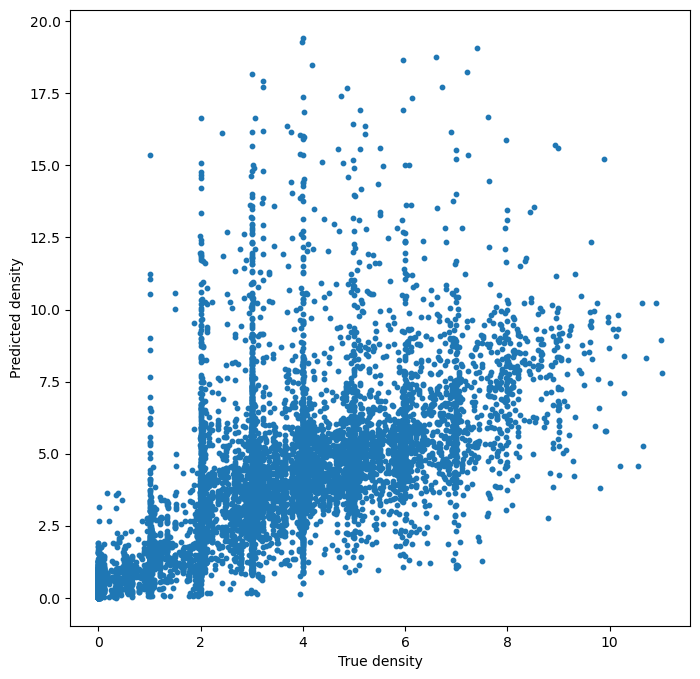

In [103]:
plt.figure(figsize = (8,8))
plt.scatter(exp_true_onecol['True_values'], exp_predicted_onecol['Forecasted_values'], s = 10)
plt.xlabel("True density")
plt.ylabel("Predicted density")
# Add the y = x line
# plt.plot([0, 3], [0, 3], color='green', label='y = x')
# plt.legend()
plt.show()

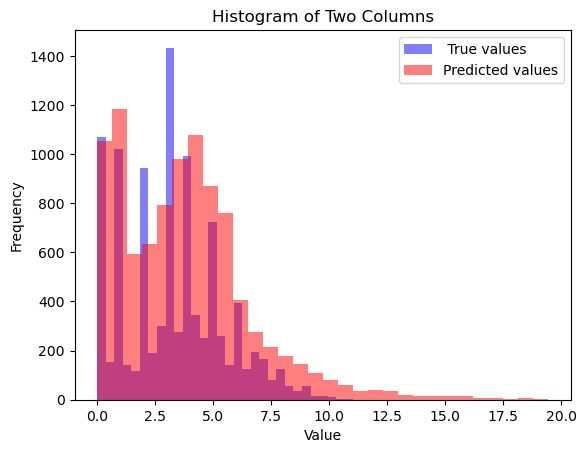

In [104]:
# At this point let's look at the true and predicted value distributions - overlay the histograms

# Plot histogram of two columns
plt.hist(exp_true_onecol['True_values'], 
         bins=30, 
         label=[' True values'], 
         alpha=0.5, color = 'blue')  # alpha = transparency
plt.hist(exp_predicted_onecol['Forecasted_values'], 
         bins=30, 
         label=['Predicted values'], 
         alpha=0.5, color = 'red') 
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Two Columns")
plt.legend()
plt.show()

In [105]:
# Should we try to get the values separated by 0s?

In [106]:
# how to do this? Maybe we need to take the indices from the true values df, and subset accordingly?

In [107]:
# so create a mask 0 with the true values 0s - we need the indices of this

In [108]:
mask_zero = exp_true_onecol['True_values'].eq(0)

In [109]:
# separate the zero and non-zero indices
idx_zero = exp_true_onecol.index[mask_zero]
idx_nonzero = exp_true_onecol.index[-mask_zero]

In [110]:
# how many zero values?
idx_zero.shape

(538,)

In [111]:
910*7

6370

In [112]:
# how many non-zeor values
idx_nonzero.shape

(9094,)

In [113]:
# sanity check
idx_nonzero.shape[0] + idx_zero.shape[0]

9632

In [114]:
# Subset both dataframes with the same indices
df_true_zero  = exp_true_onecol.loc[idx_zero]
df_pred_zero  = exp_predicted_onecol.loc[idx_zero]
df_true_nz    = exp_true_onecol.loc[idx_nonzero]
df_pred_nz    = exp_predicted_onecol.loc[idx_nonzero]

In [115]:
df_true_zero.shape, df_pred_zero.shape

((538, 1), (538, 1))

In [116]:
df_true_zero.head()

,True_values
263,0.0
270,0.0
272,0.0
273,0.0
274,0.0


In [117]:
df_pred_zero.head()

,Forecasted_values
263,0.829934
270,0.685990
272,0.669538
273,0.544980
274,0.580399


In [118]:
df_true_nz.head()

,True_values
0,4.000330
1,4.030646
2,4.054460
3,4.829047
4,4.369852


In [119]:
df_pred_nz.head()

,Forecasted_values
0,3.910323
1,3.993181
2,4.064571
3,4.360180
4,4.195281


In [120]:
# create the separate scatterplots for these

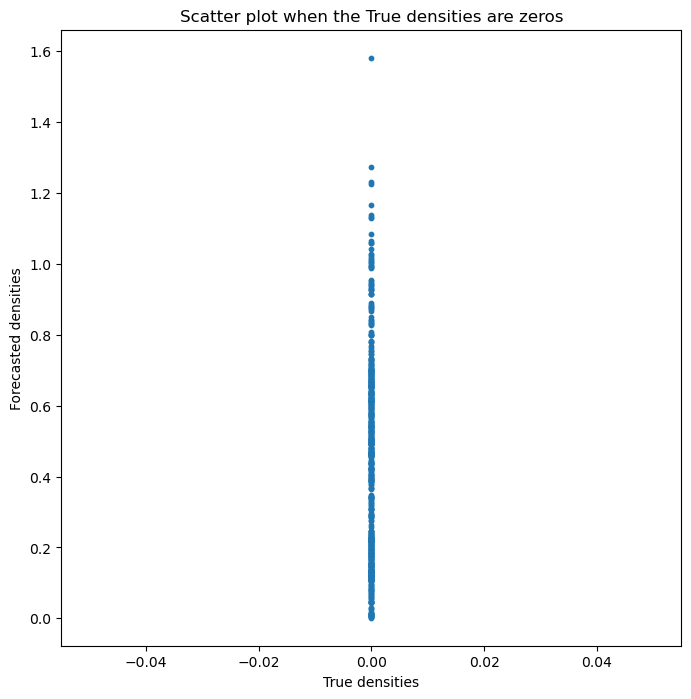

In [121]:
# For zero-data
plt.figure(figsize = (8,8))
plt.scatter(df_true_zero['True_values'], df_pred_zero['Forecasted_values'], s = 10)
plt.title("Scatter plot when the True densities are zeros")
plt.xlabel("True densities")
plt.ylabel("Forecasted densities")
plt.show()

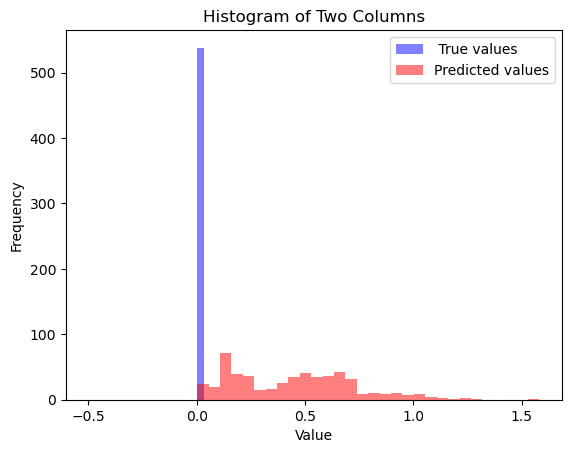

In [122]:
# Plot histogram of two columns
plt.hist(df_true_zero['True_values'], 
         bins=30, 
         label=[' True values'], 
         alpha=0.5, color = 'blue')  # alpha = transparency
plt.hist(df_pred_zero['Forecasted_values'], 
         bins=30, 
         label=['Predicted values'], 
         alpha=0.5, color = 'red') 
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Two Columns")
plt.legend()
plt.show()

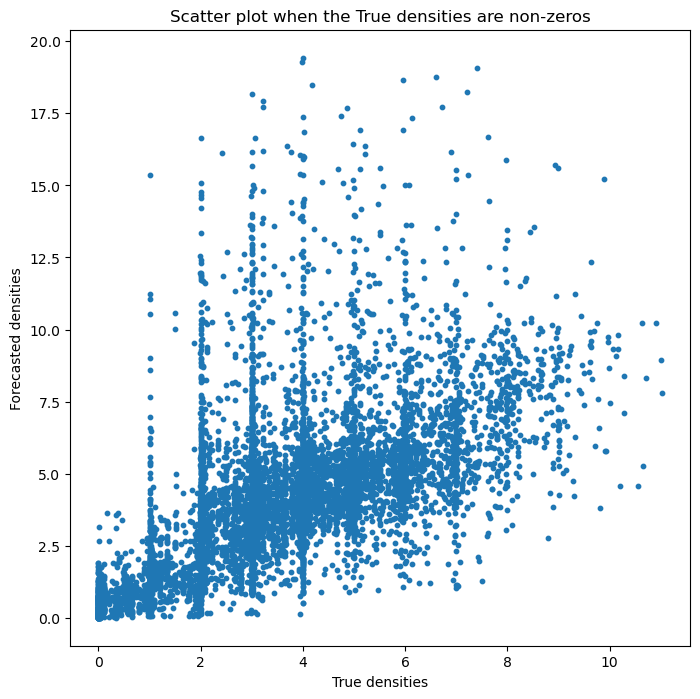

In [124]:
# For non-zero data
plt.figure(figsize = (8,8))
plt.scatter(df_true_nz['True_values'], df_pred_nz['Forecasted_values'], s = 10)
plt.title("Scatter plot when the True densities are non-zeros")
# also plot the y = x line?
# plt.plot([0, 3], [0, 3], color='green', label='y = x')
plt.xlabel("True densities")
plt.ylabel("Forecasted densities")
plt.show()

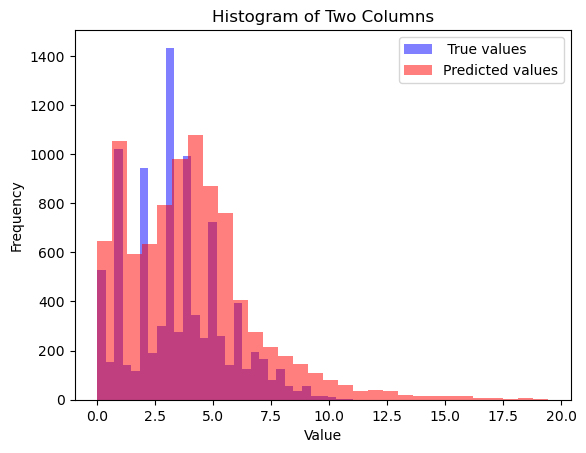

In [125]:
# Plot histogram of two columns
plt.hist(df_true_nz['True_values'], 
         bins=30, 
         label=[' True values'], 
         alpha=0.5, color = 'blue')  # alpha = transparency
plt.hist(df_pred_nz['Forecasted_values'], 
         bins=30, 
         label=['Predicted values'], 
         alpha=0.5, color = 'red') 
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Two Columns")
plt.legend()
plt.show()

In [126]:
# not that great - but maybe the model is not doing as well as we need due to the number of zeros we had considered during the model training phase?

In [127]:
# Maybe get the metrics for teh reduced subsets of data as well

In [128]:
# All zeros

In [129]:
rmse_zero =  np.sqrt(mean_squared_error(df_true_zero['True_values'], df_pred_zero['Forecasted_values']))
rmse_zero

0.5249527560429353

In [130]:
mae_zero = mean_absolute_error(df_true_zero['True_values'], df_pred_zero['Forecasted_values'])
mae_zero

0.4432184311509787

In [131]:
corr_zero = pearsonr(df_true_zero['True_values'], df_pred_zero['Forecasted_values'])

/mnt/nrdstor/statsgeneral/gayara/tfp_cpu_env/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [132]:
corr_zero

PearsonRResult(statistic=nan, pvalue=nan)

In [133]:
r2_zero = r2_score(df_true_nz['True_values'], df_pred_nz['Forecasted_values'])
r2_zero

-0.15100414609704682

In [134]:
# non zeros

In [135]:
rmse_nzero =  np.sqrt(mean_squared_error(df_true_nz['True_values'], df_pred_nz['Forecasted_values']))
rmse_nzero

2.227731240936935

In [136]:
mae_nzero = mean_absolute_error(df_true_nz['True_values'], df_pred_nz['Forecasted_values'])
mae_nzero

1.3258063555757476

In [137]:
corr_nzero = pearsonr(df_true_nz['True_values'], df_pred_nz['Forecasted_values'])

In [138]:
corr_nzero

PearsonRResult(statistic=0.6388378240292233, pvalue=0.0)

In [139]:
r2_nzero = r2_score(df_true_nz['True_values'], df_pred_nz['Forecasted_values'])
r2_nzero

-0.15100414609704682

Credible Intervals

In [140]:
all_forecasts_npy_files = ['all_forecasts_sub_' + str(i) + '.npy' for i in range(1376)]

In [141]:
%%time
loaded_npy_files = []
for file in all_forecasts_npy_files:
    joined_path = os.path.join(path_to_dfs, file)
    load_file = np.load(joined_path)
    # notice we are averaging the preds across the chains before exponentiation
    mean_file = np.mean(np.exp(load_file)-1, axis = 1)
    loaded_npy_files.append(mean_file)

CPU times: user 359 ms, sys: 110 ms, total: 469 ms
Wall time: 471 ms


In [142]:
len(loaded_npy_files)

1376

In [143]:
loaded_npy_files[0].shape

(1000, 7)

In [144]:
# Maybe we should not get rid of the negatives? - As for the percentiles we will else never capture the true values of zeros?

In [145]:
# yeah, let's proceed with these

In [146]:
# how to arrange these though? - might need to think this through a little

In [147]:
exp_true.shape

(7, 1376)

In [148]:
# where is the lsit of the forecasted range of values? - loaded_npy_files

In [149]:
len(loaded_npy_files)

1376

In [150]:
loaded_npy_files[0].shape

(1000, 7)

In [151]:
# Okay, I think we need to move along the loaded file and also its axis 1 to get the percentile values in order.

In [152]:
# create a for loop for this? - and later maybe even a function so we do not need to repeat everything for each block separately

In [153]:
# I think we also need to catch the percentiles?

In [154]:
# Let's try all these?

In [155]:
trial_0 = loaded_npy_files[0][:,0]

In [156]:
trial_0.shape

(1000,)

In [157]:
trial_li = np.percentile(trial_0, axis = 0, q = (2.5, 97.5))

In [158]:
# trial_0.min(), trial_0.max()

In [159]:
trial_li

array([3.05796348, 4.82880206])

In [160]:
trial_li[0], trial_li[1]

(3.057963478565216, 4.828802061080932)

In [161]:
lower_and_upper_limits = [] 
for j in range(loaded_npy_files[0].shape[1]):
    values = loaded_npy_files[0][:,j]
    # compute the lower and upper bounds?
    li = np.percentile(values, axis = 0, q = (2.5, 97.5))[0]    
    ui = np.percentile(values, axis = 0, q = (2.5, 97.5))[1]
    lower_and_upper_limits.append((li, ui))

In [162]:
lower_and_upper_limits

[(3.057963478565216, 4.828802061080932),
 (3.087842893600464, 5.108001220226287),
 (3.064168119430542, 5.351524782180786),
 (2.3817489743232727, 7.335083711147306),
 (2.8012571156024935, 6.279754495620727),
 (2.731354236602783, 5.913420033454893),
 (2.90413122177124, 5.967005586624145)]

In [163]:
%%time
# Do this for all files?
catch_all_percentiles = []
for i in range(len(loaded_npy_files)):
    all_lower_and_upper_limits = [] 
    for j in range(loaded_npy_files[i].shape[1]):
        values = loaded_npy_files[i][:,j]
        # compute the lower and upper bounds?
        li = np.percentile(values, axis = 0, q = (2.5, 97.5))[0]    
        ui = np.percentile(values, axis = 0, q = (2.5, 97.5))[1]
        all_lower_and_upper_limits.append((li, ui))
    catch_all_percentiles.append(all_lower_and_upper_limits)
    

CPU times: user 1.4 s, sys: 7.74 ms, total: 1.41 s
Wall time: 1.41 s


In [164]:
len(catch_all_percentiles)

1376

In [165]:
catch_inside_length = []
for limit_values in catch_all_percentiles:
    length = len(limit_values)
    catch_inside_length.append(length)

In [166]:
np.mean(catch_inside_length)

7.0

In [167]:
# We may need a multitude of sanity checks to make sure we are correctly computing the coverages and widths. Now at this point, we can go ahead and compute the CI widths using the credible intervals? As this computation seems fairly simple?

In [168]:
len(catch_all_percentiles[0])

7

In [169]:
all_percentiles_for_widths = [item for limit_values in catch_all_percentiles for item in limit_values]

In [170]:
len(all_percentiles_for_widths)

9632

In [171]:
# do some sanity check?

In [172]:
catch_all_percentiles[1]

[(3.1899851739406584, 6.318338811397552),
 (3.0278317511081694, 6.139586532115937),
 (3.294589239358902, 6.52259476184845),
 (1.7087863206863403, 9.655791306495665),
 (2.2734247922897337, 7.054068481922148),
 (2.3893366158008575, 7.094900190830231),
 (2.4654657661914827, 7.108444309234619)]

In [173]:
all_percentiles_for_widths[7:14]

[(3.1899851739406584, 6.318338811397552),
 (3.0278317511081694, 6.139586532115937),
 (3.294589239358902, 6.52259476184845),
 (1.7087863206863403, 9.655791306495665),
 (2.2734247922897337, 7.054068481922148),
 (2.3893366158008575, 7.094900190830231),
 (2.4654657661914827, 7.108444309234619)]

In [174]:
# seems this is right, let's move forward with the computation of the CI widths?

In [175]:
catch_wdths = []
for values in all_percentiles_for_widths:
    width = values[1] - values[0]
    catch_wdths.append(width)

In [176]:
# average CI width
Average_CI_width = np.mean(catch_wdths)
Average_CI_width

6.657281999806276

In [177]:
# do a few sanity checks  before we proceed?

In [178]:
catch_wdths[0:7]

[1.770838582515716,
 2.0201583266258227,
 2.2873566627502444,
 4.953334736824034,
 3.4784973800182337,
 3.18206579685211,
 3.062874364852905]

In [179]:
print(catch_all_percentiles[0][0][1] - catch_all_percentiles[0][0][0])
print(catch_all_percentiles[0][1][1] - catch_all_percentiles[0][1][0])
print(catch_all_percentiles[0][2][1] - catch_all_percentiles[0][2][0])
print(catch_all_percentiles[0][3][1] - catch_all_percentiles[0][3][0])
print(catch_all_percentiles[0][4][1] - catch_all_percentiles[0][4][0])
print(catch_all_percentiles[0][5][1] - catch_all_percentiles[0][5][0])
print(catch_all_percentiles[0][6][1] - catch_all_percentiles[0][6][0])

1.770838582515716
2.0201583266258227
2.2873566627502444
4.953334736824034
3.4784973800182337
3.18206579685211
3.062874364852905


In [180]:
# Okay, we can move on now

In [181]:
# What about the coverage?
# Now this list - all_percentiles_for_widths - this is in the oder of the subwindows - but before proceeding to the next subwindow, it also tracks across the 7 time periods.
# so now, we have the true values in a dataframe in the shape (7,910), we can stack these ina single column  - and basically then have to track if this value is inbetween the two upper and lower limits in the list all_percentiles_for_widths.

In [182]:
# cool, so let's get this true values dataset arranged  in one single column?

In [183]:
# actually, we have already done that

In [184]:
exp_true_onecol.shape

(9632, 1)

In [185]:
exp_true_onecol.head()

,True_values
0,4.000330
1,4.030646
2,4.054460
3,4.829047
4,4.369852


In [186]:
All_exp_true_vals_array = exp_true_onecol.values.reshape(-1)

In [187]:
All_exp_true_vals_array.shape

(9632,)

In [188]:
All_exp_true_vals_array.min(), All_exp_true_vals_array.max()

(0.0, 11.025154977031994)

In [189]:
# cool, now check if this value is inbetween the upper and the lower limits contained in the list - all_percentiles_for_widths

In [190]:
Catch_all_indicators = []
for i in range(All_exp_true_vals_array.shape[0]):
    true_value = All_exp_true_vals_array[i]
    li_val = all_percentiles_for_widths[i][0]
    ui_val = all_percentiles_for_widths[i][1]
    ind_train = (true_value >= li_val) & (true_value <= ui_val)
    Catch_all_indicators.append(ind_train)

In [191]:
coverage_val = np.mean(Catch_all_indicators)
coverage_val

0.8048172757475083

In [192]:
# I think we are ready to replicate this for the rest of the blocks? Let's push the recent work to GitHub

In [193]:
# define a function to get the post-hoc prediction
def prediction_on_test_data(preds_array, stride = 24, kernel_size = 300):

    img_height = 768 # we might need to verify this value
    # get the image weight
    img_width = 1024 # we might need to verify this value

    
    # create an empty density map
    Density_map = np.zeros((img_height, img_width))

    # create an empty counts map
    counts_map = np.zeros((img_height, img_width))
    
    # now, for every window, we will keep adding the values together and also add the counts
    counter = 0
#     need a counter to move into each predicted value in the pred values list
    for ii in range(0, img_height, stride):
        for jj in range(0, img_width, stride):
#         operations for density map
#             get the window of interest
            new_window = Density_map[ii:ii + kernel_size,jj:jj+kernel_size]
#     fill each with the value c_k
            counts_window = np.full((new_window.shape[0], new_window.shape[1]), preds_array[counter])
#     get the shapes of this new window
            cw_height = counts_window.shape[0]
            cw_width = counts_window.shape[1]
#         Do c_k/r_2
            counts_window_new = counts_window/(cw_height*cw_width)
#     This is the value in the window now
            value_window = counts_window_new
#     place the values in the corrsponding area of the density map
            Density_map[ii:ii + kernel_size,jj:jj+kernel_size] = new_window + value_window

#         Let's now focus on capturing the counts of the windows
            new_window_c = counts_map[ii:ii + kernel_size,jj:jj+kernel_size]
#     get the counts area
            count = np.ones((new_window_c.shape[0], new_window_c.shape[1]))
#     keep adding the counts to reflect the addition of densities
            counts_map[ii:ii + kernel_size,jj:jj+kernel_size] = new_window_c + count
#     increase the counter
            counter = counter + 1
            
#         get the normalized count
    normalized_counts = np.divide(Density_map, counts_map)
    
#     entire count on the test set
    pred_on_test = np.sum(normalized_counts)
    
#     return the predicted value
    return(pred_on_test, normalized_counts)

In [194]:
Forecasted_values_df.shape

(7, 1376)

In [195]:
Forecasted_values_df.values.shape

(7, 1376)

In [196]:
# Access just the first row?

In [197]:
Forecasted_values_df.values[0,:].shape

(1376,)

In [198]:
# use this to get the preds?

In [199]:
test_im_0_preds = prediction_on_test_data(Forecasted_values_df.values[0,:], stride = 24, kernel_size = 300)

In [200]:
test_im_0_preds[0]

41.04389067192528

In [201]:
# get the values forecasted in a loop?
predicted_test_values = []
for i in range(7):
    pred_val = prediction_on_test_data(Forecasted_values_df.values[i,:], stride = 24, kernel_size = 300)[0]
    predicted_test_values.append(pred_val)

In [202]:
predicted_test_values

[41.04389067192528,
 41.29191342909923,
 43.87894558531615,
 53.0639672312697,
 53.75740705551421,
 51.49015055739303,
 51.38090748351959]

In [269]:
# Okay, there's some seroius shit happening I think with those very high values - we need to figuer out what to do